# Imports

In [300]:
import xgboost as xgb
from autograd import grad, hessian, elementwise_grad
import pandas as pd
import matplotlib.pyplot as plt
import autograd.numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

from scipy.stats import percentileofscore
import time
import math

# Training data

In [239]:
df = pd.read_parquet('../pipeline/tmp/cities/poz-w/dataset_50_stops.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,reference,time
0,0.994687,-1.925553,-0.141699,0.518964,0,0.504468,3251,5715
1,0.994687,-1.925553,0.216683,-0.231768,0,0.504468,1627,3158
2,-0.767035,1.589467,0.254793,0.689781,2,0.099178,2657,8527
3,0.455074,-0.001201,0.078837,0.048088,1,0.783380,744,1394
4,-1.071253,-0.765113,0.302267,-0.454654,0,0.679792,3483,5585


In [240]:
print(df.size)

32000000


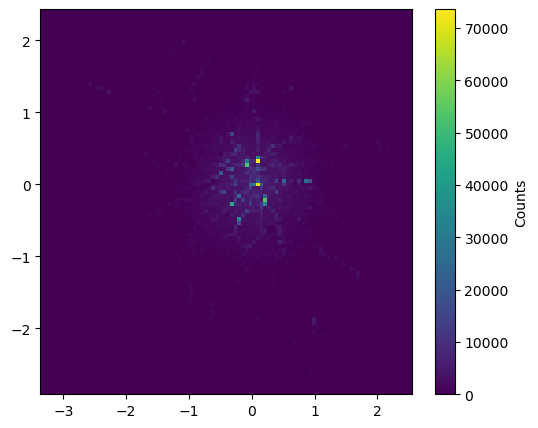

In [241]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [242]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [309]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model definitions

## parameters

### NN

In [224]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential'),
])

In [225]:
model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])

### XGB

In [321]:
params = {
    'reg:squarederror'
    'max_depth': 6,
    'eta': 1e9,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 7,
    #'base_score': mean_y_train
}
num_rounds = 100

## loss function

### NN

In [227]:
def quadrtic(ratio):
    return (1-ratio)**2

def squized_sigmoid(ratio):
    return 1/(1 + tf.math.exp(-30*(ratio-1)))

In [228]:
def asymetric_loss_function(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    
    #tf.print("y_true:", y_true, summarize=-1)
    #tf.print("y_pred:", y_pred, summarize=-1)

    tf.debugging.assert_all_finite(y_pred, "y_pred contains NaN values!")
    
    tf.debugging.assert_greater_equal(
        tf.reduce_min(y_pred), tf.constant(0.0, dtype=tf.float32),
        message=f"y_pred contains negative values! {y_pred}"
    )

    ratio = y_pred / y_true
    
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    )
    sigmoid = squized_sigmoid(ratio)
    loss = quadrtic(ratio)*(1-sigmoid)+3*ratio*sigmoid

    return tf.reduce_mean(loss)

### XGB

In [322]:
def np_asymetric_loss_function(y_true, y_pred):
    #print("y_true:", y_true, "  y_pred: ", y_pred)
    y_pred = abs(y_pred)

    ratio = y_pred / y_true
    
    def quadratic(ratio):
        return (1 - ratio) ** 2
    
    def squeezed_sigmoid(ratio):
        return 1 / (1 + np.exp(-30 * (ratio - 1)))
    
    sigmoid = squeezed_sigmoid(ratio)
    loss = quadratic(ratio) * (1 - sigmoid) + 3 * ratio * sigmoid
    
    return loss.mean()

def xgb_eval_metric(preds, dtrain):
    labels = dtrain.get_label()
    metric_name = "asymetric_loss"
    metric_value = np_asymetric_loss_function(labels, preds)
    return metric_name, metric_value

In [323]:
def xgb_custom_obj(preds, dtrain):
    #print("preds: ", preds)
    labels = dtrain.get_label()
    #print("labels: ", labels)
    grad = grad_custom_loss(labels, preds)
    #print("grad magnitude: ", np.linalg.norm(grad))
    #print("grad: ", grad)
    hess = hess_custom_loss(labels, preds)
    #print("hess: ", hess)
    return grad, hess

In [326]:
def squared_error(preds: np.ndarray, dtrain: xgb.DMatrix):
    labels = dtrain.get_label()
    grad = preds - labels
    hess = np.ones_like(grad)
    return grad, hess

# Training

### NN

In [232]:
history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_split=0.2)

Epoch 1/16
 5500/80000 [=>............................] - ETA: 3:19 - loss: 0.8034 - mape: 84.8339

KeyboardInterrupt: 

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpup1i0vls\assets


### XGB

In [330]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
#xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, obj=xgb_custom_obj, custom_metric=xgb_eval_metric, verbose_eval=10)
xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, obj=squared_error, verbose_eval=10)
#xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10)

c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:24] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "reg:squarederrormax_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4708602682857.84570	eval-rmse:4708023955842.47070


ValueError: could not convert string to float: '-nan(ind)'

In [258]:
batch_size = 10000

# Create batches of DMatrix
num_batches = int(np.ceil(X_train.shape[0] / batch_size))
dtrain_batches = [xgb.DMatrix(X_train[i*batch_size:(i+1)*batch_size], label=y_train[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
# Initialize the Booster
model = None
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model with custom loss function and custom evaluation function in batches
num_rounds_per_batch = 100
total_rounds = 10000
rounds_per_batch = total_rounds // num_batches

for i, dtrain_batch in enumerate(dtrain_batches):
    print(f"Training on batch {i+1}/{num_batches}")
    if model is None:
        model = xgb.train(params, dtrain_batch, rounds_per_batch, evals=evals, obj=xgb_custom_obj, feval=xgb_eval_metric, verbose_eval=10)
        #xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10)
    else:
        model = xgb.train(params, dtrain_batch, rounds_per_batch, evals=evals, obj=xgb_custom_obj, feval=xgb_eval_metric, verbose_eval=10, xgb_model=model)
        #xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10, xgb_model=model)

Training on batch 1/320
grad:  (10000,)
hess:  (10000,)


c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:59] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "reg:squarederrormax_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:2875.93529	train-asymetric_loss:4.09619	eval-rmse:2880.26973	eval-asymetric_loss:4.09612
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
[10]	train-rmse:2875.93529	train-asymetric_loss:4.09619	eval-rmse:2880.26973	eval-asymetric_loss:4.09612
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
grad:  (10000,)
hess:  (10000,)
[20]	train-rmse:2875.93529	train-asymetric_loss:4.09619	eval-rmse:2880.26973	eval-asymetric_loss:4.09612
grad:  (10000,)
hess:  (10000,)
grad:  (10000,

c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "reg:squarederrormax_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:2875.93529	train-asymetric_loss:4.09619	eval-rmse:2880.26973	eval-asymetric_loss:4.09612
grad:  (10000,)
hess:  (10000,)


KeyboardInterrupt: 

# Quantization

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_float16_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpmwdlzqsx\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpmwdlzqsx\assets


In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_dynamic_range_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjek6xcih\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjek6xcih\assets


In [19]:
X_test_uint8 = ((X_test / np.max(X_test)) * 255).astype(np.uint8)
X_train_uint8 = ((X_train / np.max(X_train))*255).astype(np.uint8)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset
def representative_dataset():
    for _ in range(100000):
        # Get sample input data as a numpy array in the correct shape
        yield [X_train_uint8[:1]]

converter.representative_dataset = representative_dataset

# Ensure that input and output tensors are quantized
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_full_integer_quant.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Cannot losslessly cast from float64 to uint8

# Model evaluation

## Read tflite model

In [37]:
with open('model.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.resize_tensor_input(input_details[0]['index'], (1, 6))
interpreter.allocate_tensors()

## predicitons on test set

### NN

In [38]:
nn_y_pred = []

for i in range(X_test.shape[0]):
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    nn_y_pred.append(output_data[0][0])

nn_y_pred = np.array(nn_y_pred)

mape = mean_absolute_percentage_error(y_test, nn_y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Absolute Percentage Error (MAPE): 0.40%


### XGB

In [130]:
xgb_y_pred = abs(xgb_model.predict(dtest))

# Evaluate the model using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, xgb_y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Absolute Percentage Error (MAPE): 99.98%


## Visualize set results distribution

### code

In [131]:
def plot_results_distribution(y_pred):    
    percentage_difference = ((y_pred - y_test) / y_test) * 100
    #percentage_difference = y_pred - y_test

    percentile_1 = np.percentile(percentage_difference, 1)
    percentile_99 = np.percentile(percentage_difference, 99.9)
    max_overestimation = np.max(percentage_difference)
    percentile_of_0 = percentileofscore(percentage_difference, 0)

    plt.figure(figsize=(10, 6))
    sns.histplot(percentage_difference, kde=True, bins=100, color='blue')

    plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
    plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

    plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
    plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

    plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
    plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

    plt.xlabel('Percentage Difference (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Percentage Difference Between Predictions and Targets')
    plt.legend()
    plt.show()

    print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
    print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

### NN

In [53]:
plot_results_distribution(nn_y_pred)

NameError: name 'nn_y_pred' is not defined

### XGB

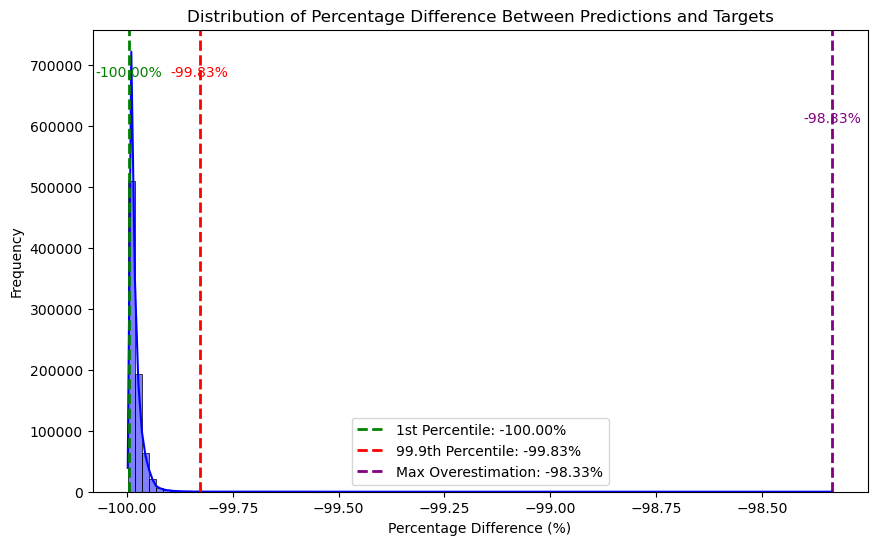

Maximal Overestimation Value: -98.33%
Percentile for 0 on x-axis value: 100.00%


In [132]:
plot_results_distribution(xgb_y_pred)

## Forward pass time

In [40]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test.shape[0])
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    start_time = time.perf_counter()
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.perf_counter()
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 8.108460 microseconds
total time for 10000 rows: 81.08460056246258 milliseconds
